In [1]:
import numpy as np
import os

from scipy.stats import pearsonr
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
def info_timeseries(region, model, season, path_in):
    region = region.lower()
    season = season.lower()
    model = model.lower()
    
    if season == 'djf':
        years = np.arange(1994, 2018, 1)
    if season == 'jja':
        years = np.arange(1993, 2017, 1)
    file_name = os.path.join(
            path_in,
            f'timeseries_{season}_{region}.npz'
        )
    data = np.load(file_name)

    data_model = data[model]
    data_merra2 = data['merra2']
    
    # Calculate mean over the gridpoints
    data_model = np.nanmean(data_model, axis = 1)
    data_merra2 = np.nanmean(data_merra2, axis = 1)
    
    # Calculate ensemble mean for the seasonal forecast system
    data_model_ensemble_mean = np.nanmean(data_model, axis = -1)

    # Calculate temporal over the study period (years)
    model_temporal_mean = np.nanmean(data_model_ensemble_mean)
    merra2_temporal_mean = np.nanmean(data_merra2)
    
    # Anomalies
    model_ensemblemean_anomalies = data_model_ensemble_mean - model_temporal_mean
    merra2_anomalies = data_merra2 - merra2_temporal_mean
    model_ensemblemembers_anomalies = data_model - np.reshape(model_temporal_mean, (1, 1))
    
    # ACC
    r_pearson = pearsonr(merra2_anomalies, model_ensemblemean_anomalies)
    
    m = model_ensemblemembers_anomalies.shape[-1] 
    df = pd.DataFrame({'years': years.repeat(m),
                      'ensemble': np.tile(np.arange(1, m+1, 1), years.size),
                     'data': model_ensemblemembers_anomalies.flatten()})
    
    return(df, r_pearson, model_ensemblemean_anomalies, merra2_anomalies, years)

In [3]:
path_in = '../../outputs/timeseries'

season = 'djf'  # 'djf' or 'jja'
regions = ['r1', 'r2', 'r3']
models = ['cfsv2', 'seas5']

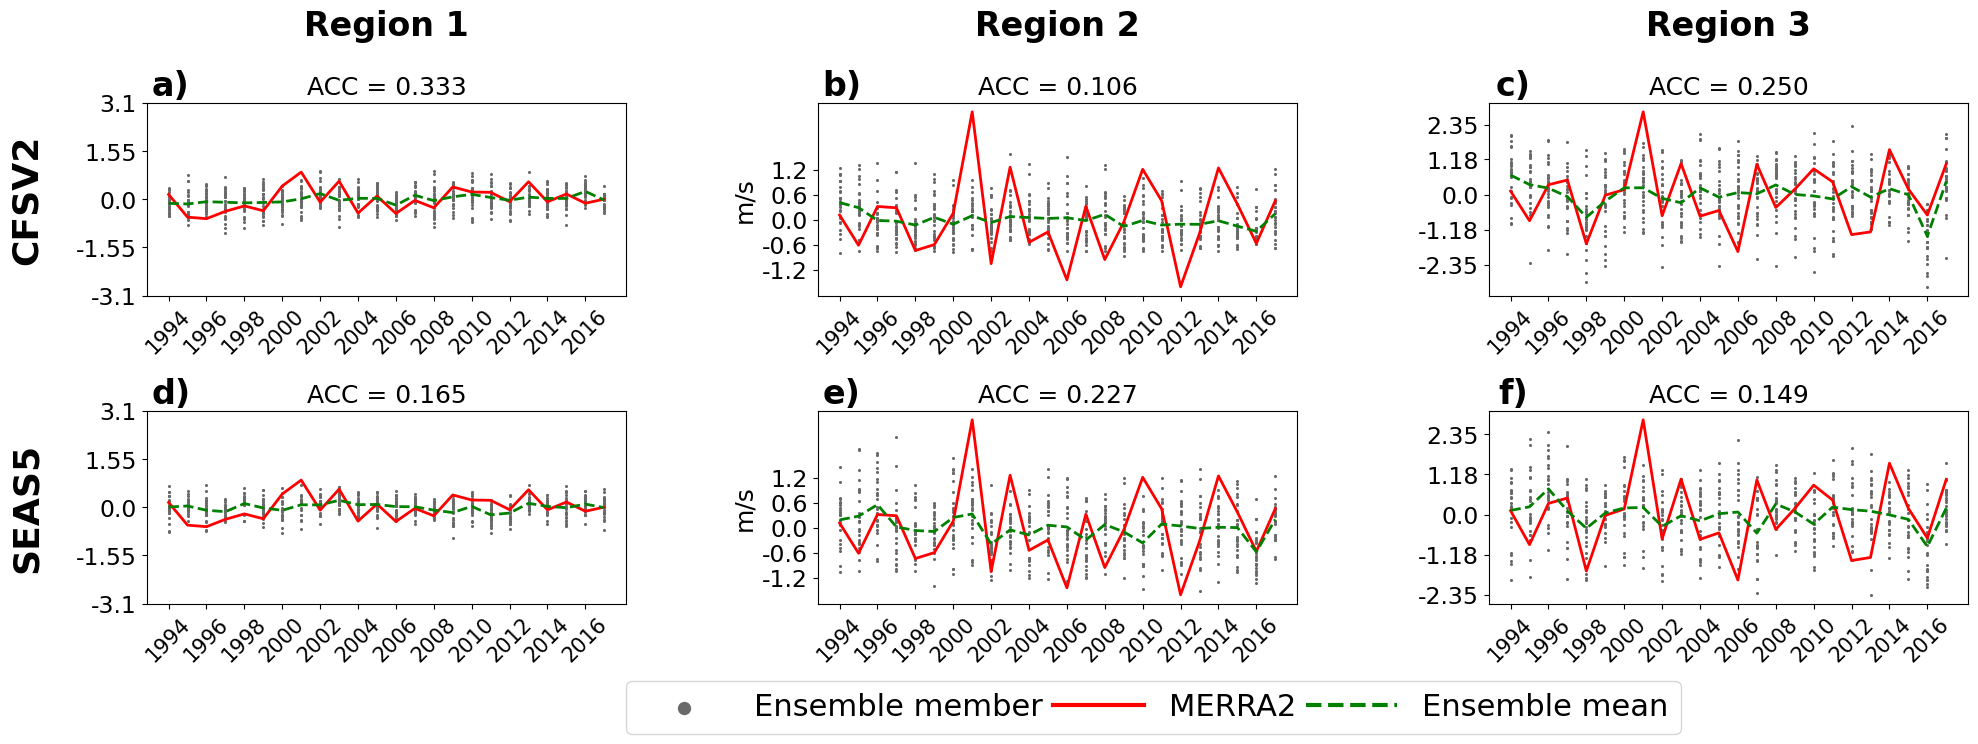

In [5]:
season = 'djf'
models = ['cfsv2', 'seas5']
regions = ['r1', 'r2', 'r3']
letters = np.array([['a)', 'b)', 'c)'], ['d)', 'e)', 'f)']])

yticks_dict = {
    'r1': np.round(np.linspace(-3.1, 3.1, 5), 2),
    'r2': np.round(np.linspace(-1.2, 1.2, 5), 2),
    'r3': np.round(np.linspace(-2.35, 2.35, 5), 2),
}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(23.5, 6.5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for ax, (i, model, j, region) in zip(axes.flat, [(i, m, j, r) for i, m in enumerate(models) for j, r in enumerate(regions)]):
    ensemble_membsers, r, ensemble_mean, reanalysis, years = info_timeseries(region, model, season, path_in)

    ax.scatter(ensemble_membsers['years'], ensemble_membsers["data"], marker=".", c='dimgray', s=6, label='Ensemble member')
    ax.plot(years, reanalysis, color="red", linewidth=2, label="MERRA2")
    ax.plot(years, ensemble_mean, color='green', linestyle='dashed', linewidth=2, label='Ensemble mean')

    ax.set_xticks(years[::2])
    ax.set_xticklabels(years[::2], rotation=45, fontsize=15)
    ax.set_title(f"ACC = {r.statistic:.3f}", fontsize=18)

    # Set y ticks
    yticks = yticks_dict[region]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=17)

    if region == 'r2':
        ax.set_ylabel('m/s', fontsize=18)

    ax.annotate(letters[i, j], xy=(0.05, 1.09), xycoords='axes fraction', fontsize=24, fontweight='bold', ha='center', va='center')

    if i == 0:
        ax.text(0.5, 1.4, f'Region {j+1}', ha='center', va='center', fontweight='bold', fontsize=24, transform=ax.transAxes)

    if j == 0:
        ax.text(-0.25, 0.5, model.upper(), ha='center', va='center', fontweight='bold', fontsize=26, rotation='vertical', transform=ax.transAxes)

legend = ax.legend(bbox_to_anchor=(-1.8, -0.5, 2.2, .1), loc=1, ncol=3, mode="expand", borderaxespad=0, markerscale=7, handlelength=3, prop={'size': 22})

for line in legend.get_lines():
    line.set_linewidth(3.0)

# figname = os.path.join(path_out, f'timeseries'_{season}'.jpeg')
# plt.savefig(figname,dpi=700,bbox_inches='tight')

plt.show()
